In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 30  # predict 30 days in the future

In [3]:
def preprocess_features(daily_adjusted_df, prediction_period, index_ordering=None, truncate_end=True):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]
    processed_features = selected_features.copy()
    ta.add_all_ta_features(processed_features, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    
    # Remove constant features
    processed_features = processed_features.iloc[:, processed_features.std().values > 0.00001]
    
    # TODO: normalize whole df
    # processed_features = (processed_features - processed_features.mean()) / processed_features.std()
    
    # Don't include the most recent prediction_period days
    if truncate_end:
        processed_features = processed_features.iloc[prediction_period:]

    if index_ordering is not None:
        processed_features.reindex(index_ordering)
    return processed_features

def preprocess_targets(daily_adjusted_df, prediction_period, index_ordering=None, truncate_start=True):
    processed_targets = daily_adjusted_df[["adjusted_close"]].copy()
    
    # Don't include the oldest prediction_period days
    if truncate_start:
        processed_targets = processed_targets.iloc[:-prediction_period]

    if index_ordering is not None:
        processed_targets.reindex(index_ordering)
    return processed_targets

In [4]:
num_rows = len(daily_adjusted_df)
# Use 90% for training and rest for validation
num_training = int(num_rows * 0.9)
num_validation = num_rows - num_training

# TODO: split up data more intelligently
random_ordering = np.random.permutation(daily_adjusted_df.index)
training_examples = preprocess_features(daily_adjusted_df.tail(num_training), prediction_period, random_ordering[-num_training:])
training_targets = preprocess_targets(daily_adjusted_df.tail(num_training), prediction_period, random_ordering[-num_training:])

validation_examples = preprocess_features(daily_adjusted_df.head(num_validation), prediction_period, random_ordering[:num_validation])
validation_targets = preprocess_targets(daily_adjusted_df.head(num_validation), prediction_period, random_ordering[:num_validation])

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5334.000000,5334.000000,5334.000000,5334.000000,5.334000e+03,5.334000e+03,5.334000e+03,5.334000e+03,5334.000000,5.334000e+03,...,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000,5334.000000
mean,53.344848,54.053577,52.645373,21.316167,4.431532e+07,-2.568454e+09,1.190040e+05,9.743015e+04,-37.294875,-3.948264e+05,...,49.635093,-5.131495,-0.191114,-404.618623,-404.446244,-504.618623,0.020816,-0.035017,-0.056099,-59.634282
std,35.025364,35.561068,34.475214,9.720931,3.138240e+07,1.821027e+09,5.397171e+07,1.686829e+07,23.824608,3.430723e+07,...,13.635478,13.547420,1.855168,341.795349,337.158997,341.795349,6.211221,2.054789,2.052766,18.408205
min,15.200000,15.620000,14.870000,2.423500,7.111000e+05,-1.686254e+10,-5.910522e+08,-7.018803e+07,-165.300606,-1.222927e+09,...,7.862745,-40.613998,-17.829201,-2831.970874,-2723.100894,-2931.970874,-18.905735,-16.370530,-17.877422,-95.410698
25%,27.080000,27.312500,26.900000,17.105550,2.395645e+07,-3.397081e+09,-4.062915e+07,-8.009842e+06,-50.017373,-1.945473e+06,...,39.995259,-14.786609,-0.616790,-558.423463,-557.037997,-658.423463,-1.322886,-1.031635,-1.036994,-67.607788
50%,35.180000,35.670000,34.840000,20.530100,4.158840e+07,-2.203019e+09,0.000000e+00,-1.731750e+05,-32.657822,-6.826970e+03,...,49.771063,-4.945372,-0.023121,-318.683129,-320.524817,-418.683129,-0.194618,0.000000,0.000000,-61.122831
75%,71.120000,72.090000,70.202500,24.840975,5.952180e+07,-1.209516e+09,4.155992e+07,7.786281e+06,-18.392660,1.688296e+06,...,59.234311,5.072332,0.313201,-154.254910,-156.026979,-254.254910,0.999532,0.927940,0.923661,-52.959470
max,178.940000,180.380000,175.750000,53.162000,5.910522e+08,-1.865601e+08,3.193179e+08,1.185872e+08,-4.456276,6.094328e+08,...,95.412496,27.952980,11.930493,57.302205,54.329791,-42.697795,73.606765,18.492853,16.968246,0.671116


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,566.000000,566.000000,566.000000,566.000000,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,566.000000,5.660000e+02,...,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,72.754211,73.292832,72.193007,71.138853,2.594655e+07,-2.069084e+08,-2.446424e+06,-2.325006e+06,-3.976436,-3.505570e+05,...,44.609916,-18.878282,4.652032,-11.987246,-11.900015,-111.987246,-1.462139,-0.131509,-0.138819,-36.669765
std,15.546076,15.718988,15.328382,16.172756,1.199398e+07,1.517093e+08,2.834583e+07,8.112428e+06,2.475264,1.984395e+07,...,13.709652,7.275716,15.586150,44.187576,42.574208,44.187576,1.553834,1.200328,1.203664,14.397539
min,48.920000,49.146600,48.035000,46.176000,7.425503e+06,-7.842726e+08,-1.268341e+08,-2.223885e+07,-10.157916,-1.157829e+08,...,5.978444,-38.753959,-37.691036,-149.038462,-134.883932,-249.038462,-6.273228,-7.037796,-7.297718,-58.892549
25%,60.035000,60.520000,59.630000,57.678875,1.927288e+07,-3.047249e+08,-2.394791e+07,-7.867989e+06,-5.982160,-2.650043e+06,...,35.599240,-23.116597,-4.430072,-36.771421,-37.173103,-136.771421,-2.433929,-0.728786,-0.731455,-48.652297
50%,69.380000,69.910000,68.855000,68.102750,2.314941e+07,-1.791312e+08,-1.517237e+07,-3.040352e+06,-3.684665,-6.617042e+04,...,44.271391,-18.459038,0.196559,-8.992257,-8.392134,-108.992257,-1.180151,-0.085489,-0.085525,-39.372607
75%,86.053750,86.307500,85.241250,84.625450,2.946649e+07,-8.539885e+07,2.208404e+07,2.373580e+06,-1.701829,1.965795e+06,...,52.871384,-13.967809,8.527055,16.103983,16.864865,-83.896017,-0.423726,0.449144,0.448139,-24.663536
max,108.080000,108.200000,106.080000,105.857000,1.335030e+08,1.904017e+07,1.335030e+08,3.011413e+07,-0.434164,2.603319e+08,...,87.447525,-4.373933,42.900894,88.899814,79.225722,-11.100186,2.363941,5.411131,5.269805,-5.762486


Training targets summary:


,adjusted_close
count,5334.000000
mean,21.592747
std,9.880709
min,2.454300
25%,17.170425
50%,20.618150
75%,24.973375
max,53.451400


Validation targets summary:


,adjusted_close
count,566.000000
mean,74.304003
std,17.254035
min,46.176000
25%,60.446450
50%,70.823950
75%,90.057800
max,112.330000


In [5]:
display.display(validation_examples.head(7))
display.display(validation_targets.head(7))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
30,108.08,108.20,106.080,105.8570,56038827,-5.554925e+07,-56038827,-6552946.7,-0.520334,-4.115337e+07,...,33.082130,-28.298562,38.323477,17.167449,33.223787,-82.832551,0.000000,-1.574518,-1.587045,-5.762486
31,104.93,105.31,103.890,103.9943,40171646,-1.020985e+08,-40171646,-7959685.5,-0.543743,-3.721349e+07,...,31.235517,-28.182601,38.299068,1.436639,20.757440,-98.563361,0.000000,-1.759638,-1.775304,-7.420725
32,105.94,106.05,104.715,104.7115,29493927,-6.391895e+07,29493927,-2647422.9,-0.587464,3.040718e+07,...,37.033258,-27.620433,37.031099,11.315427,9.973172,-88.684573,0.000000,0.689653,0.687286,-6.782249
33,104.61,106.50,104.320,105.5383,25901726,-2.659978e+07,25901726,2708264.9,-0.580598,-2.203276e+07,...,42.445782,-26.636998,37.068365,22.703857,11.818641,-77.296143,-2.119543,0.789598,0.786497,-6.046203
34,105.40,105.82,104.515,104.5023,21786912,-1.916216e+07,-21786912,3996406.4,-0.569661,1.612308e+06,...,42.192469,-26.168216,28.449632,8.433884,14.151056,-91.566116,-2.307793,-0.981634,-0.986484,-6.968486
35,104.37,105.60,104.090,105.0203,24653500,-1.648678e+07,24653500,2761227.2,-0.529366,6.465811e+05,...,47.895677,-25.474035,33.440254,15.568871,15.568871,-84.431129,-2.555616,0.495683,0.494458,-6.507344
36,102.77,104.41,102.730,103.7851,24335929,1.195592e+07,-24335929,-2809576.7,-0.452686,-1.828155e+06,...,47.875555,-25.290101,31.997996,12.530879,12.177878,-87.469121,-2.538675,-1.176154,-1.183125,-7.606962


,adjusted_close
0,112.33
1,111.95
2,112.02
3,110.26
4,109.60
5,108.40
6,107.56


In [6]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [7]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [8]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 2983056.96
  period 01 : 2176260.56
  period 02 : 713447.24
  period 03 : 1343697.83
  period 04 : 168680.80
  period 05 : 106948.63
  period 06 : 467028.64
  period 07 : 516684.58
  period 08 : 753894.80
  period 09 : 485122.03
Model training finished.
Final RMSE (on training data):   485122.03
Final RMSE (on validation data): 309159.63


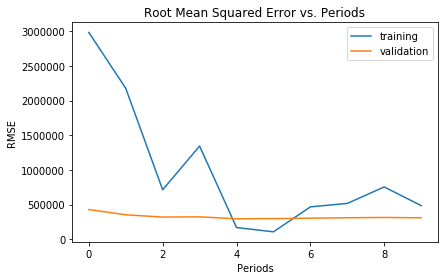

In [10]:
regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
    steps=1500,
    batch_size=50,
    hidden_units=[30, 30, 30, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [11]:
recent_examples = preprocess_features(daily_adjusted_df.head(prediction_period + 365), prediction_period, truncate_end=False).head(prediction_period)
recent_targets = preprocess_targets(daily_adjusted_df.head(prediction_period), prediction_period, truncate_start=False)
predict_recent_input_fn = lambda: input_fn(recent_examples, recent_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_recent_input_fn)
predictions = [item['predictions'][0] for item in predictions]
display.display(predictions)

[-303660.22,
 -807006.06,
 -215409.75,
 -794574.06,
 -751666.94,
 -854482.75,
 -678692.4,
 -726176.1,
 -645181.4,
 427280.1,
 3829.8828,
 269721.88,
 649963.0,
 -80796.86,
 -528139.7,
 87933.49,
 -39025.273,
 -435651.78,
 -852303.4,
 -697868.94,
 -511164.2,
 -1038868.1,
 -484106.06,
 -41289.47,
 -265343.62,
 1553545.9,
 -199430.95,
 -86029.86,
 -176546.36,
 646651.1]